## Retail Data Transformation and Analysis with PySpark

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, count, countDistinct,desc
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
spark = SparkSession.builder.appName("Retail Data Transformation").getOrCreate()

In [0]:
df = spark.read.csv("dbfs:/FileStore/Retail_Store_Chain_Analysis/4_final_data.csv", 
                     header=True, inferSchema=True)

In [0]:
df

DataFrame[Row ID: int, Order ID: string, Order Date: date, Ship Date: date, Ship Mode: string, Customer ID: string, Customer Name: string, Segment: string, Country: string, City: string, State: string, Postal Code: int, Region: string, Product ID: string, Category: string, Sub-Category: string, Product Name: string, Sales: double, Order Year: int, Order Month: int]

In [0]:
df.show(1, truncate=False)

+------+--------------+----------+----------+--------------+-----------+-------------+--------+-------------+-------+-----+-----------+-------+---------------+---------------+------------+------------------------------------------------------------------------+------+----------+-----------+
|Row ID|Order ID      |Order Date|Ship Date |Ship Mode     |Customer ID|Customer Name|Segment |Country      |City   |State|Postal Code|Region |Product ID     |Category       |Sub-Category|Product Name                                                            |Sales |Order Year|Order Month|
+------+--------------+----------+----------+--------------+-----------+-------------+--------+-------------+-------+-----+-----------+-------+---------------+---------------+------------+------------------------------------------------------------------------+------+----------+-----------+
|7981  |CA-2015-103800|2015-01-03|2015-01-07|Standard Class|DP-13000   |Darren Powers|Consumer|United States|Houston|Texas|7

In [0]:
display(df)

In [0]:
df.select("Sales").summary().show()

+-------+------------------+
|summary|             Sales|
+-------+------------------+
|  count|              9800|
|   mean|140.81584877550767|
| stddev| 169.5517360055789|
|    min|             0.444|
|    25%|             17.24|
|    50%|            54.384|
|    75%|           210.564|
|    max|           500.641|
+-------+------------------+



In [0]:
# get the unique columns count in the DataFrame
columns = df.columns
for col_name in columns:
    df.select(countDistinct(col_name).alias(f"Unique {col_name}")).show()

+-------------+
|Unique Row ID|
+-------------+
|         9800|
+-------------+

+---------------+
|Unique Order ID|
+---------------+
|           4922|
+---------------+

+-----------------+
|Unique Order Date|
+-----------------+
|             1230|
+-----------------+

+----------------+
|Unique Ship Date|
+----------------+
|            1326|
+----------------+

+----------------+
|Unique Ship Mode|
+----------------+
|               4|
+----------------+

+------------------+
|Unique Customer ID|
+------------------+
|               793|
+------------------+

+--------------------+
|Unique Customer Name|
+--------------------+
|                 793|
+--------------------+

+--------------+
|Unique Segment|
+--------------+
|             3|
+--------------+

+--------------+
|Unique Country|
+--------------+
|             1|
+--------------+

+-----------+
|Unique City|
+-----------+
|        529|
+-----------+

+------------+
|Unique State|
+------------+
|          49|
+---------

### Product hierarchy organization

In [0]:
# Group products by Category and Sub-Category to analyze product hierarchy
product_hierarchy = df.groupBy("Category", "Sub-Category").agg(count("*").alias("Count")).orderBy("Category", desc("Count"))
product_hierarchy.show(truncate=False)


+---------------+------------+-----+
|Category       |Sub-Category|Count|
+---------------+------------+-----+
|Furniture      |Furnishings |931  |
|Furniture      |Chairs      |607  |
|Furniture      |Tables      |314  |
|Furniture      |Bookcases   |226  |
|Office Supplies|Binders     |1492 |
|Office Supplies|Paper       |1338 |
|Office Supplies|Storage     |832  |
|Office Supplies|Art         |785  |
|Office Supplies|Appliances  |459  |
|Office Supplies|Labels      |357  |
|Office Supplies|Envelopes   |248  |
|Office Supplies|Fasteners   |214  |
|Office Supplies|Supplies    |184  |
|Technology     |Phones      |876  |
|Technology     |Accessories |756  |
|Technology     |Machines    |115  |
|Technology     |Copiers     |66   |
+---------------+------------+-----+



In [0]:
# List distinct products with their Category and Sub-Category
product_hierarchy = df.select("Category", "Sub-Category", "Product Name").distinct().orderBy("Category", "Sub-Category")
product_hierarchy.show(truncate=False)

+---------+------------+------------------------------------------------------------------------+
|Category |Sub-Category|Product Name                                                            |
+---------+------------+------------------------------------------------------------------------+
|Furniture|Bookcases   |Hon Metal Bookcases, Gray                                               |
|Furniture|Bookcases   |Bush Westfield Collection Bookcases, Dark Cherry Finish                 |
|Furniture|Bookcases   |O'Sullivan Elevations Bookcase, Cherry Finish                           |
|Furniture|Bookcases   |Global Adaptabilites Bookcase, Cherry/Storm Gray Finish                 |
|Furniture|Bookcases   |Rush Hierlooms Collection 1" Thick Stackable Bookcases                  |
|Furniture|Bookcases   |Safco Value Mate Steel Bookcase, Baked Enamel Finish on Steel, Black    |
|Furniture|Bookcases   |O'Sullivan Manor Hill 2-Door Library in Brianna Oak                     |
|Furniture|Bookcases

- The **Furniture** category offers a variety of products, with **Furnishings** being the most popular, while **Bookcases** have fewer choices.
- **Office Supplies** includes many items, especially **Binders** and **Paper**, which are top-selling products.
- **Technology** features fewer options, with **Phones** being the most common, and **Copiers** being the least popular.


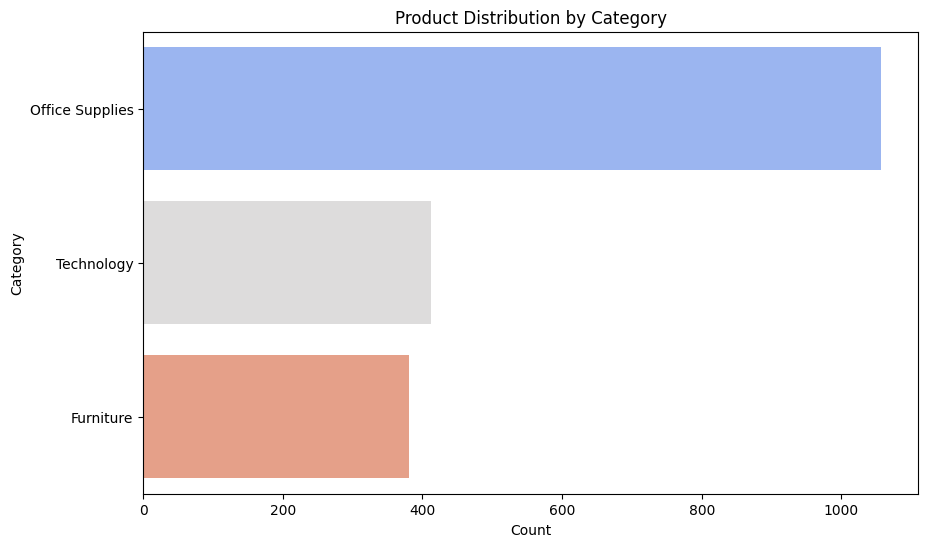

In [0]:
# Plot
product_hierarchy_pd = product_hierarchy.toPandas()
plt.figure(figsize=(10, 6))
sns.countplot(data=product_hierarchy_pd, y="Category", order=product_hierarchy_pd["Category"].value_counts().index, palette="coolwarm")
plt.title("Product Distribution by Category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()


### Sales aggregations by Region and Category


In [0]:
# Aggregating total and average sales by region
sales_by_region = df.groupBy('Region').agg(
    sum('Sales').alias('Total Sales'),
    avg('Sales').alias('Average Sales')
).orderBy('Total Sales', ascending=False)
sales_by_region.show()


+-------+------------------+------------------+
| Region|       Total Sales|     Average Sales|
+-------+------------------+------------------+
|   West|453913.02400000347|144.55828789809027|
|   East| 393061.5650000013|141.13521184919256|
|Central| 306869.5690000008|134.76924418094018|
|  South|226151.16000000082|141.52137672090163|
+-------+------------------+------------------+



In [0]:
# Aggregating total and average sales by product category
sales_by_category = df.groupBy('Category').agg(
    sum('Sales').alias('Total Sales'),
    avg('Sales').alias('Average Sales')
).orderBy('Total Sales', ascending=False)
sales_by_category.show()

+---------------+------------------+-----------------+
|       Category|       Total Sales|    Average Sales|
+---------------+------------------+-----------------+
|Office Supplies|  484165.922000003|81.93703198510796|
|      Furniture|473164.65700000233|227.7019523580377|
|     Technology| 422664.7390000012|233.1300270270277|
+---------------+------------------+-----------------+



In [0]:
# Sales aggregations by Region and Category
sales_by_region_category = df.groupBy("Region", "Category").agg(
    sum("Sales").alias("Total Sales"),
    avg("Sales").alias("Average Sales"),
    count("Order ID").alias("Total Orders")
).orderBy('Total Sales', ascending=False)
sales_by_region_category.show(truncate=False)

+-------+---------------+------------------+------------------+------------+
|Region |Category       |Total Sales       |Average Sales     |Total Orders|
+-------+---------------+------------------+------------------+------------+
|West   |Furniture      |161259.6230000003 |233.37137916063722|691         |
|West   |Office Supplies|152806.81000000006|82.15419892473122 |1860        |
|West   |Technology     |139846.59100000042|237.43054499151177|589         |
|East   |Office Supplies|139213.38800000006|83.51133053389326 |1667        |
|East   |Furniture      |131085.88200000022|221.80352284263995|591         |
|East   |Technology     |122762.29500000027|232.94553130929845|527         |
|Central|Furniture      |107413.19100000024|228.53870425531966|470         |
|Central|Office Supplies|107119.92500000006|76.56892423159404 |1399        |
|Central|Technology     |92336.45300000018 |226.31483578431417|408         |
|South  |Office Supplies|85025.79900000007 |86.4962349949136  |983         |

1. **West** has the highest sales overall.
2. **Technology** category has the highest sales and average.
3. **Furniture** shows strong sales, especially in the **West** and **Central** regions.
4. **Office Supplies** has consistent sales, but lower averages.
5. **South** has the lowest total sales.

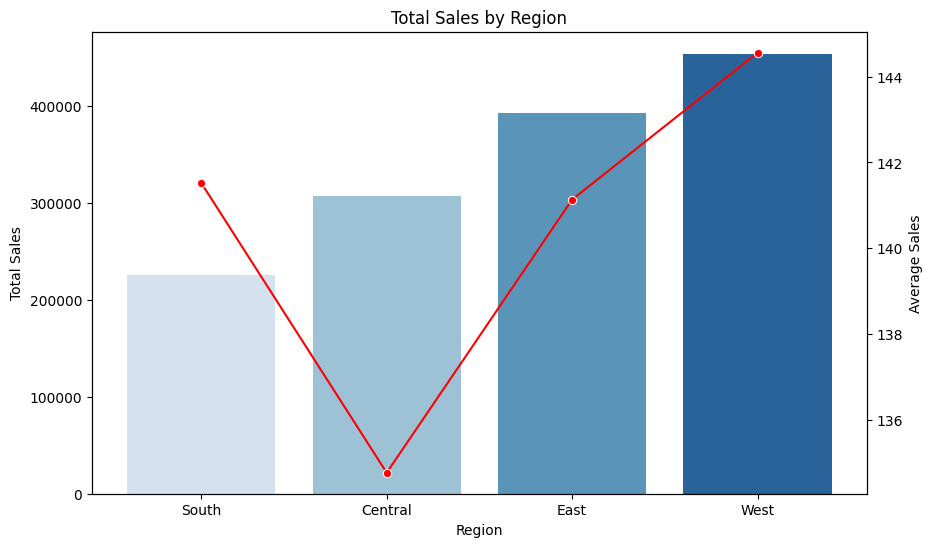

In [0]:
# Plot
sales_by_region_pd = sales_by_region.toPandas()

fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=sales_by_region_pd, x="Region", y="Total Sales", palette="Blues", ax=ax1)
ax1.set_ylabel("Total Sales")
ax1.set_xlabel("Region")
ax1.set_title("Total Sales by Region")
# Secondary Y-axis for Average Sales
ax2 = ax1.twinx()
sns.lineplot(data=sales_by_region_pd, x="Region", y="Average Sales", marker="o", color="red", ax=ax2)
ax2.set_ylabel("Average Sales")

plt.show()


### Product Sales Summary by Total Sales and Orders

In [0]:
# Calculate total sales and number of orders per product
product_sales_summary = df.groupBy("Product ID", "Product Name").agg(
    sum("Sales").alias("Total Sales"),
    count("Order ID").alias("Total Orders")
)
product_sales_summary.show(truncate=False)


+---------------+------------------------------------------------------------------------------------+------------------+------------+
|Product ID     |Product Name                                                                        |Total Sales       |Total Orders|
+---------------+------------------------------------------------------------------------------------+------------------+------------+
|FUR-BO-10003966|Sauder Facets Collection Library, Sky Alder Finish                                  |1427.683          |4           |
|OFF-BI-10000320|GBC Plastic Binding Combs                                                           |172.69199999999998|10          |
|TEC-MA-10003626|Hewlett-Packard Deskjet 6540 Color Inkjet Printer                                   |1001.282          |2           |
|OFF-SU-10004737|Acme Design Stainless Steel Bent Scissors                                           |88.92000000000002 |3           |
|OFF-AP-10002892|Belkin F5C206VTEL 6 Outlet Surge      

- Products like *Rubbermaid Chairmats* have high sales despite fewer orders.
- Items like *GBC Binding Combs* are ordered more frequently, showing steady demand.
- Sales vary due to price differences and customer preferences.

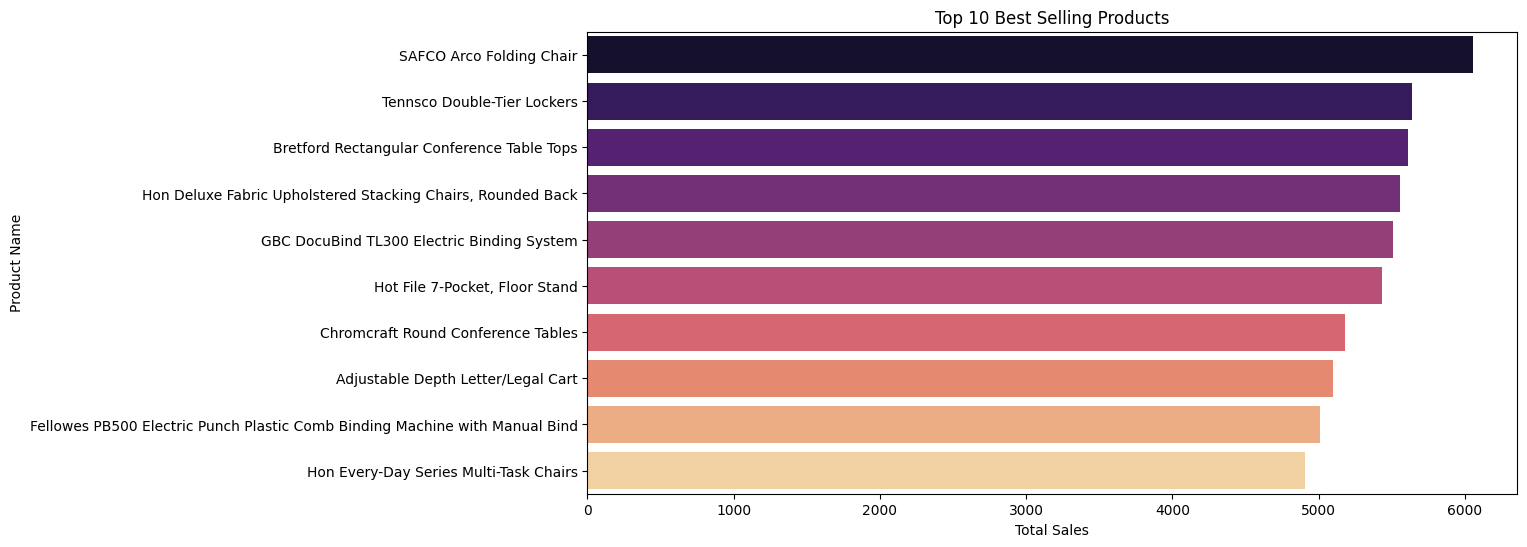

In [0]:
# Plot
product_sales_summary_pd = product_sales_summary.toPandas()
top_products = product_sales_summary_pd.nlargest(10, "Total Sales")

plt.figure(figsize=(12, 6))
sns.barplot(data=top_products, y="Product Name", x="Total Sales", palette="magma")
plt.title("Top 10 Best Selling Products")
plt.xlabel("Total Sales")
plt.ylabel("Product Name")
plt.show()


### Customer purchase patterns

In [0]:
# Calculate total purchases and total spending per customer
customer_patterns = df.groupBy("Customer ID", "Customer Name").agg(
    countDistinct("Order ID").alias("Total Purchases"),
    sum("Sales").alias("Total Spent")
)
customer_patterns.orderBy(col("Total Purchases").desc()).show(truncate=False)

+-----------+-------------------+---------------+------------------+
|Customer ID|Customer Name      |Total Purchases|Total Spent       |
+-----------+-------------------+---------------+------------------+
|EP-13915   |Emily Phan         |17             |4428.900000000001 |
|JE-15745   |Joel Eaton         |13             |4285.412          |
|PG-18820   |Patrick Gardner    |13             |2992.5480000000007|
|ZC-21910   |Zuschuss Carroll   |13             |4550.5779999999995|
|CK-12205   |Chloris Kastensmidt|13             |2615.504          |
|KD-16495   |Keith Dawkins      |12             |3610.316          |
|KB-16585   |Ken Black          |12             |2231.551          |
|NS-18640   |Noel Staavos       |12             |2857.7530000000006|
|SH-19975   |Sally Hughsby      |12             |2425.0609999999997|
|SJ-20125   |Sanjit Jacobs      |12             |2815.1140000000005|
|BD-11320   |Bill Donatelli     |12             |3030.395          |
|RB-19465   |Rick Bensley       |1

In [0]:
# Analyzing customer purchases over the years
yearly_purchase = df.select( "Customer ID","Order Year").groupBy("Customer ID", "Order Year").count().orderBy("Customer ID", "Order Year")
yearly_purchase.show(truncate=False)

+-----------+----------+-----+
|Customer ID|Order Year|count|
+-----------+----------+-----+
|AA-10315   |2015      |4    |
|AA-10315   |2016      |1    |
|AA-10315   |2017      |4    |
|AA-10315   |2018      |2    |
|AA-10375   |2015      |2    |
|AA-10375   |2016      |4    |
|AA-10375   |2017      |4    |
|AA-10375   |2018      |5    |
|AA-10480   |2015      |1    |
|AA-10480   |2017      |10   |
|AA-10480   |2018      |1    |
|AA-10645   |2015      |6    |
|AA-10645   |2016      |3    |
|AA-10645   |2017      |8    |
|AA-10645   |2018      |1    |
|AB-10015   |2015      |4    |
|AB-10015   |2017      |2    |
|AB-10060   |2016      |1    |
|AB-10060   |2017      |9    |
|AB-10060   |2018      |8    |
+-----------+----------+-----+
only showing top 20 rows



- Some customers shop regularly, while others buy less often.  
- A few customers spend a lot more than others.  
- Buying habits change from year to year.  

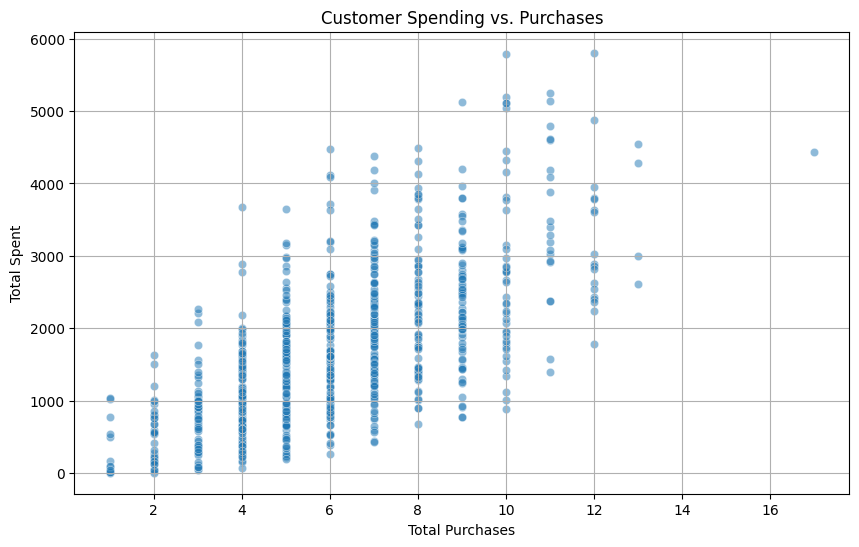

In [0]:
#  Plot
customer_patterns_pd = customer_patterns.toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_patterns_pd, x="Total Purchases", y="Total Spent", alpha=0.5)
plt.title("Customer Spending vs. Purchases")
plt.xlabel("Total Purchases")
plt.ylabel("Total Spent")
plt.grid(True)
plt.show()


### Seasonal Sales Trends

In [0]:
# Aggregating total sales, average sales, and total orders by year and month
seasonal_sales = df.groupBy("Order Year","Order Month").agg(
    sum("Sales").alias("Total Sales"),
    avg("Sales").alias("Average Sales"),
    count("Order ID").alias("Total Orders")
).orderBy("Order Year","Order Month")
seasonal_sales.show(truncate=False, n=df.count())


+----------+-----------+------------------+------------------+------------+
|Order Year|Order Month|Total Sales       |Average Sales     |Total Orders|
+----------+-----------+------------------+------------------+------------+
|2015      |1          |9912.735999999997 |128.73683116883115|77          |
|2015      |2          |3764.3130000000006|81.83289130434784 |46          |
|2015      |3          |21980.143999999997|142.72820779220777|154         |
|2015      |4          |18542.315999999995|142.63319999999996|130         |
|2015      |5          |16460.423         |136.03655371900825|121         |
|2015      |6          |20751.617999999988|158.40929770992358|131         |
|2015      |7          |20371.605999999992|143.462014084507  |142         |
|2015      |8          |20172.545999999977|138.16812328767108|146         |
|2015      |9          |37564.479000000036|140.6909325842698 |267         |
|2015      |10         |21706.353000000003|136.51794339622643|159         |
|2015      |

Sales increase from **2015 to 2018**, peaking in **November and December** each year. **January and February** have the lowest sales. **Average Sales per Order** fluctuates, with higher values in the holiday season.

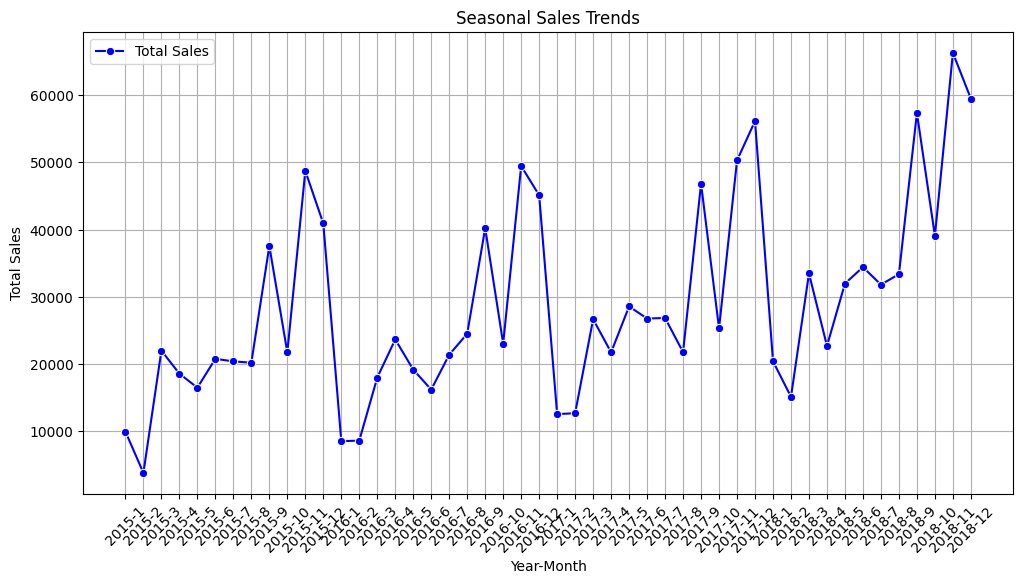

In [0]:

seasonal_sales_pd = seasonal_sales.toPandas()
seasonal_sales_pd.columns = ["Year", "Month", "Total Sales", "Average Sales", "Total Orders"]
seasonal_sales_pd = seasonal_sales_pd.sort_values(by=["Year", "Month"])

# Create a Year-Month column
seasonal_sales_pd["Year-Month"] = seasonal_sales_pd["Year"].astype(str) + "-" + seasonal_sales_pd["Month"].astype(str)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=seasonal_sales_pd, x="Year-Month", y="Total Sales", marker="o", label="Total Sales", color="blue")
plt.xticks(rotation=45)
plt.xlabel("Year-Month")
plt.ylabel("Total Sales")
plt.title("Seasonal Sales Trends")
plt.legend()
plt.grid(True)
plt.show()
